In [21]:
import json
import argparse

# 命令行参数解析
parser = argparse.ArgumentParser()
parser.add_argument('--train_xj', type=str, default=None, help='训练轴承列表, 逗号分隔')
parser.add_argument('--test_xj', type=str, default=None, help='测试轴承列表, 逗号分隔')
parser.add_argument('--context_xj', type=str, default=None, help='上下文轴承列表, 逗号分隔')
parser.add_argument('--validation_xj', type=str, default=None, help='验证轴承列表, 逗号分隔')
args, unknown = parser.parse_known_args()

with open('../../config/tcn_config.json', 'r') as f:
    config = json.load(f)

# 解析命令行参数，优先级高于config
if args.train_xj is not None:
    TRAIN_xj = [x.strip() for x in args.train_xj.split(',') if x.strip()]
else:
    TRAIN_xj = config['train_bearings']
if args.test_xj is not None:
    TEST_xj = [x.strip() for x in args.test_xj.split(',') if x.strip()]
else:
    TEST_xj = config['test_bearings']
if args.context_xj is not None:
    CONTEXT_xj = [x.strip() for x in args.context_xj.split(',') if x.strip()]
else:
    CONTEXT_xj = config['context_bearings']
if args.validation_xj is not None:
    VALIDATION_xj = [x.strip() for x in args.validation_xj.split(',') if x.strip()]
else:
    VALIDATION_xj = config['validation_bearings']

batch_size = config['batch_size']
test_batch_size = config['test_batch_size']
window_size = config['window_size']
input_dim = config['input_dim']
output_dim = config['output_dim']
num_channels = config['num_channels']
kernel_size = config['kernel_size']
dropout = config['dropout']
epochs = config['epochs']
learn_rate = config['learn_rate']
seed = config['seed']
patience = config['patience']
opt = config['opt']

if patience == "inf":
    patience = epochs
else:
    patience = int(patience)

# 加载数据
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch.nn as nn
import os
torch.autograd.set_detect_anomaly(True)
# 参数与配置
torch.manual_seed(seed)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前运行设备: {device}")
from torch.optim.lr_scheduler import CosineAnnealingLR
FPT_dict_xj = {'Bearing1_1': 76, 'Bearing1_2': 44, 'Bearing1_3': 60, 'Bearing1_4': 0, 'Bearing1_5': 39,
            'Bearing2_1': 455, 'Bearing2_2': 48, 'Bearing2_3': 327, 'Bearing2_4': 32, 'Bearing2_5': 141,
            'Bearing3_1': 2344, 'Bearing3_2': 0, 'Bearing3_3': 340, 'Bearing3_4': 1418, 'Bearing3_5': 9}
# 加载数据集
def dataloader(batch_size, test_batch_size, workers=min(8, os.cpu_count()), window_size=7):
    # 根据TRAIN_xj，TEST_xj从datasetresult/xjtu_made目录下加载相应训练集和测试集的数据和标签
    def get_data_and_labels(bearing_list, data_dir='../../datasetresult/xjtu_made', window_size=window_size, is_test=False):
        data_list = []
        label_list = []
        for bearing in bearing_list:
            # 文件名格式: c*_Bearing*_*_data, c*_Bearing*_*_label
            # 只要包含该bearing名即可
            data_files = [f for f in os.listdir(data_dir) if bearing in f and f.endswith('_fpt_data')]
            label_files = [f for f in os.listdir(data_dir) if bearing in f and f.endswith('_fpt_label')]
            # 按文件名排序，确保一一对应
            data_files.sort()
            label_files.sort()
            for data_file, label_file in zip(data_files, label_files):
                data = load(os.path.join(data_dir, data_file))
                label = load(os.path.join(data_dir, label_file))
                # 如果是测试集，且FPT_dict_xj中有该bearing，截取FPT值往后的数据
                # if is_test and bearing in FPT_dict_xj:
                #     fpt = FPT_dict_xj[bearing]
                #     # FPT为0时，保留全部数据
                #     if fpt > 0:
                #         data = data[fpt:]
                #         label = label[fpt:]
                data_list.append(data)
                label_list.append(label)
        # 拼接所有轴承的数据
        if len(data_list) > 0:
            data_all = torch.cat([torch.tensor(d) if not isinstance(d, torch.Tensor) else d for d in data_list], dim=0)
            label_all = torch.cat([torch.tensor(l) if not isinstance(l, torch.Tensor) else l for l in label_list], dim=0)
        else:
            data_all = torch.empty(0)
            label_all = torch.empty(0)
        return data_all, label_all

    # 加载训练集和测试集
    train_set, train_label = get_data_and_labels(TRAIN_xj)
    context_set, context_label = get_data_and_labels(CONTEXT_xj)
    test_set, test_label = get_data_and_labels(TEST_xj, is_test=True)
    validation_set, validation_label = get_data_and_labels(VALIDATION_xj)
    print(train_set.shape, train_label.shape)
    print(test_set.shape, test_label.shape)
    
    # 加载数据 - 性能优化：限制worker数量，添加pin_memory加速GPU传输
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_set, train_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=False,
                                   pin_memory=True, persistent_workers=True if workers > 0 else False)
    context_loader = Data.DataLoader(dataset=Data.TensorDataset(context_set, context_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=False,
                                   pin_memory=True, persistent_workers=True if workers > 0 else False)
    # 注意：如果测试集样本数小于batch_size，drop_last=True会导致所有数据被丢弃
    # 因此对于测试集和验证集，应该使用drop_last=False以确保所有数据都被处理
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_set, test_label),
                                  batch_size=test_batch_size, num_workers=workers, drop_last=False,
                                  pin_memory=True, persistent_workers=True if workers > 0 else False)
    validation_loader = Data.DataLoader(dataset=Data.TensorDataset(validation_set, validation_label),
                                   batch_size=test_batch_size, num_workers=workers, drop_last=False,
                                   pin_memory=True, persistent_workers=True if workers > 0 else False)
    return train_loader, context_loader, test_loader, validation_loader

# 加载数据
train_loader, context_loader, test_loader, validation_loader = dataloader(batch_size, test_batch_size, window_size=window_size)

print(len(train_loader.dataset))
print(len(context_loader.dataset))
print(len(test_loader.dataset))
print(len(validation_loader.dataset))

当前运行设备: cuda
torch.Size([174, 1, 11]) torch.Size([174, 1])
torch.Size([97, 1, 11]) torch.Size([97, 1])
174
46
97
97


In [22]:
# 定义裁剪模块
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

#  定义 TCN 卷积+残差 模块
from torch.nn.utils import parametrizations

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.5):
        super(TemporalBlock, self).__init__()
        # 第一层 卷积
        self.conv1 = parametrizations.weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 因为 padding 的时候, 在序列的左边和右边都有填充, 所以要裁剪
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # 第二层 卷积
        self.conv2 =parametrizations.weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        # 1×1的卷积. 只有在进入Residual block的通道数与出Residual block的通道数不一样时使用.
        # 一般都会不一样, 除非num_channels这个里面的数, 与num_inputs相等. 例如[5,5,5], 并且num_inputs也是5
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None  # 进行下采样

        # 在整个Residual block中有非线性的激活
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        out = out + res
        out = self.relu(out)
        return out

In [23]:
import torch.nn.functional as F

attention_dim = 1  # 因为输入的最后一维是1
class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        # 将输入维度从1映射到attention_dim
        self.query = nn.Linear(1, embed_dim)
        self.key = nn.Linear(1, embed_dim) 
        self.value = nn.Linear(1, embed_dim)
        
    def forward(self, x):
        # x shape: (batch_size=1024, seq_len=128, features=1)
        # 对最后一维进行线性变换
        q = self.query(x)  # (1024, 128, embed_dim)
        k = self.key(x)    # (1024, 128, embed_dim)
        v = self.value(x)  # (1024, 128, embed_dim)
        
        # 计算注意力权重
        attention_weights = F.softmax(torch.matmul(q, k.transpose(1, 2)) / torch.sqrt(torch.tensor(self.embed_dim)), dim=-1)
        # 应用注意力权重
        output = torch.matmul(attention_weights, v)  # (1024, 128, embed_dim)
        return output

In [24]:
# 定义 TCN 预测模型
class TCN(nn.Module):
    def __init__(self, batch_size, input_dim, output_dim, num_channels, kernel_size, dropout= 0.5):
        super(TCN, self).__init__()
        self.batch_size = batch_size
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_dim if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        
        self.network = nn.Sequential(*layers)

        # 序列平局池化  为什么加这个进去，输入 [32, 7, 8] ->[32, 7, 64] 序列长度 做一个平均池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(num_channels[-1], output_dim)
        self.attention = SelfAttention(embed_dim=1)
        # 自适应平均池化
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        # CNN 输入 （batch_size, channels, length）
        # 调换维度[B, L, D] --> [B, D, L]
        x = x.permute(0,2,1)
        out = self.network(x)  # torch.Size([32, 64, 1])
        out = self.attention(out)
        out = self.adaptive_pool(out)
        # 序列平均池化操作
        output_avgpool = self.avgpool(out)  #  torch.Size([32, 64, 1])
        output_avgpool = output_avgpool.reshape(output_avgpool.size(0), -1)  #  torch.Size([32, 64])
        predict = self.fc(output_avgpool)  #  输出维度为[batch_size, output_dim]
        return predict

In [25]:
# 输入数据维度为[batch_size, sequence_length, input_size]
# 输出维度为[batch_size, output_dim]
model = TCN(batch_size, input_dim, output_dim, num_channels, kernel_size, dropout) 
print(model)
# 定义损失函数和优化函数
loss_function = nn.MSELoss()  # loss
if config['opt'] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器
elif config['opt'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), learn_rate)  # 使用AdamW优化器
elif config['opt'] == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), learn_rate)  # 使用SGD优化器
else:
    raise ValueError(f"Invalid optimizer: {config['opt']}")
# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): ParametrizedConv1d(
        11, 32, kernel_size=(5,), stride=(1,), padding=(4,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.3, inplace=False)
      (conv2): ParametrizedConv1d(
        32, 32, kernel_size=(5,), stride=(1,), padding=(4,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.3, inplace=False)
      (net): Sequential(
        (0): ParametrizedConv1d(
          11, 32, kernel_size=(5,), stride=(1,), padding=(4,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
      

In [26]:
print(model)

TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): ParametrizedConv1d(
        11, 32, kernel_size=(5,), stride=(1,), padding=(4,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.3, inplace=False)
      (conv2): ParametrizedConv1d(
        32, 32, kernel_size=(5,), stride=(1,), padding=(4,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.3, inplace=False)
      (net): Sequential(
        (0): ParametrizedConv1d(
          11, 32, kernel_size=(5,), stride=(1,), padding=(4,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
      

Epoch:  1 train_MSE-Loss: 0.98570770
Epoch:  2 train_MSE-Loss: 0.97013205
Epoch:  3 train_MSE-Loss: 0.96935254
Epoch:  4 train_MSE-Loss: 0.97357231
Epoch:  5 train_MSE-Loss: 0.97295547
Epoch:  6 train_MSE-Loss: 0.96664935
Epoch:  7 train_MSE-Loss: 0.95967680
Epoch:  8 train_MSE-Loss: 0.94510877
Epoch:  9 train_MSE-Loss: 0.91404068
Epoch: 10 train_MSE-Loss: 0.85514140
Epoch: 11 train_MSE-Loss: 0.71573395
Epoch: 12 train_MSE-Loss: 0.52095950
Epoch: 13 train_MSE-Loss: 0.46875355


Epoch: 14 train_MSE-Loss: 0.41139665
Epoch: 15 train_MSE-Loss: 0.32756850
Epoch: 16 train_MSE-Loss: 0.29915580
Epoch: 17 train_MSE-Loss: 0.32493344
Epoch: 18 train_MSE-Loss: 0.28021476
Epoch: 19 train_MSE-Loss: 0.23221403
Epoch: 20 train_MSE-Loss: 0.20571150
Epoch: 21 train_MSE-Loss: 0.19709821
Epoch: 22 train_MSE-Loss: 0.16169319
Epoch: 23 train_MSE-Loss: 0.14269076
Epoch: 24 train_MSE-Loss: 0.14242861
Epoch: 25 train_MSE-Loss: 0.13557880
Epoch: 26 train_MSE-Loss: 0.13538158
Epoch: 27 train_MSE-Loss: 0.11100381
Epoch: 28 train_MSE-Loss: 0.09688552
Epoch: 29 train_MSE-Loss: 0.10673819
Epoch: 30 train_MSE-Loss: 0.09271624
Epoch: 31 train_MSE-Loss: 0.08051247
Epoch: 32 train_MSE-Loss: 0.07091102
Epoch: 33 train_MSE-Loss: 0.07085477
Epoch: 34 train_MSE-Loss: 0.06883107
Epoch: 35 train_MSE-Loss: 0.06097311
Epoch: 36 train_MSE-Loss: 0.05897089
Epoch: 37 train_MSE-Loss: 0.06133029
Epoch: 38 train_MSE-Loss: 0.05709129
Epoch: 39 train_MSE-Loss: 0.05397762
Epoch: 40 train_MSE-Loss: 0.05410417
E

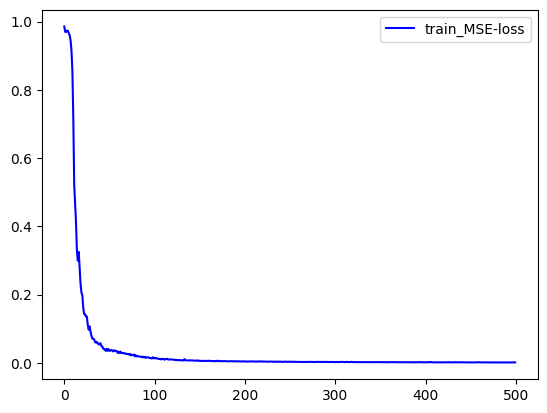

min_MSE: 0.000794191553723067


In [27]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt

def model_train(epochs, model, optimizer, loss_function, train_loader, device):
    model = model.to(device)

    # 最低MSE  
    minimum_mse = 1000.
    # 最佳模型
    best_model = model

    train_mse = []     # 记录在训练集上每个epoch的 MSE 指标的变化情况   平均值
  
    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
         # 训练
        model.train()
        train_mse_loss = []    #保存当前epoch的MSE loss和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 损失计算
            loss = loss_function(y_pred, labels)
            train_mse_loss.append(loss.item()) # 计算 MSE 损失
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        # 计算总损失
        train_av_mseloss = np.average(train_mse_loss) # 平均
        train_mse.append(train_av_mseloss)
        print(f'Epoch: {epoch+1:2} train_MSE-Loss: {train_av_mseloss:10.8f}')
       
        # 如果当前模型的 MSE 低于于之前的最佳准确率，则更新最佳模型
        #保存当前最优模型参数
        if train_av_mseloss < minimum_mse:
            minimum_mse = train_av_mseloss
            best_model = model # 更新最佳模型的参数
         
    # 保存最后的参数
    # torch.save(model.state_dict(), 'final_model_tcn.pt')
    # 保存最好的参数
    torch.save(best_model.state_dict(), 'best_model_tcn.pt')
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    
    # 可视化
    plt.plot(range(epochs), train_mse, color = 'b',label = 'train_MSE-loss')
    plt.legend()
    plt.show()   #显示 lable 
    print(f'min_MSE: {minimum_mse}')

#  模型训练
model_train(epochs, model, optimizer, loss_function, train_loader, device)

# 测试集评估

In [28]:
# 模型 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型的状态字典
model.load_state_dict(torch.load('best_model_tcn.pt'))
model = model.to(device)

# 预测数据
test_origin_data = []
test_pre_data = []
with torch.no_grad():
    for data, label in test_loader:
        # 原始标签
        origin_lable = label.tolist()
        test_origin_data += origin_lable
        model.eval()  # 将模型设置为评估模式
        
        # 预测
        data, label = data.to(device, non_blocking=True), label.to(device, non_blocking=True)
        pred = model(data)  # 对测试集进行预测
        pred = pred.tolist()
        test_pre_data += pred        

In [29]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler_dir = '../../datasetresult/xjtu_made'
scaler_filename = f'{TEST_xj[0]}_labeled_fpt_scaler'
all_files = os.listdir(scaler_dir)
matched_files = [f for f in all_files if f.endswith(scaler_filename)]
if not matched_files:
    raise FileNotFoundError(f"未找到匹配 {TEST_xj[0]} 的 scaler 文件, 目录: {scaler_dir}")
scaler_path = os.path.join(scaler_dir, matched_files[0])
scaler = load(scaler_path)

print(matched_files)
print(f"原始数据长度: {len(test_origin_data)}")
print(f"预测数据长度: {len(test_pre_data)}")

# 确保数据是一维数组（处理嵌套列表的情况）
# 如果数据是嵌套列表 [[val1], [val2], ...]，需要先展平
test_origin_data = np.array(test_origin_data).flatten()
test_pre_data = np.array(test_pre_data).flatten()

print(f"展平后原始数据形状: {test_origin_data.shape}")
print(f"展平后预测数据形状: {test_pre_data.shape}")

# 反归一化：确保数据是二维数组 (n_samples, n_features) 格式
# scaler.inverse_transform 需要 (n_samples, n_features) 格式的输入
test_origin_data = scaler.inverse_transform(test_origin_data.reshape(-1, 1)).flatten()
test_pre_data = scaler.inverse_transform(test_pre_data.reshape(-1, 1)).flatten()


# 模型分数
score = r2_score(test_origin_data, test_pre_data)
print('测试集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
test_mse = mean_squared_error(test_origin_data, test_pre_data)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_origin_data, test_pre_data)
print('测试数据集上的均方误差-MSE: ',test_mse)
print('测试数据集上的均方根误差-RMSE: ',test_rmse)
print('测试数据集上的平均绝对误差-MAE: ',test_mae)

['c1_Bearing1_3_labeled_fpt_scaler']
原始数据长度: 97
预测数据长度: 97
展平后原始数据形状: (97,)
展平后预测数据形状: (97,)
测试集上 模型分数-R^2: 0.2527715402155628
**************************************************
测试数据集上的均方误差-MSE:  0.06226242017326498
测试数据集上的均方根误差-RMSE:  0.24952438793285311
测试数据集上的平均绝对误差-MAE:  0.19825598140393974


/root/miniconda3/envs/myconda/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


/root/miniconda3/envs/myconda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23551 (\N{CJK UNIFIED IDEOGRAPH-5BFF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/myconda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21629 (\N{CJK UNIFIED IDEOGRAPH-547D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/myconda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/myconda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/myconda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarni

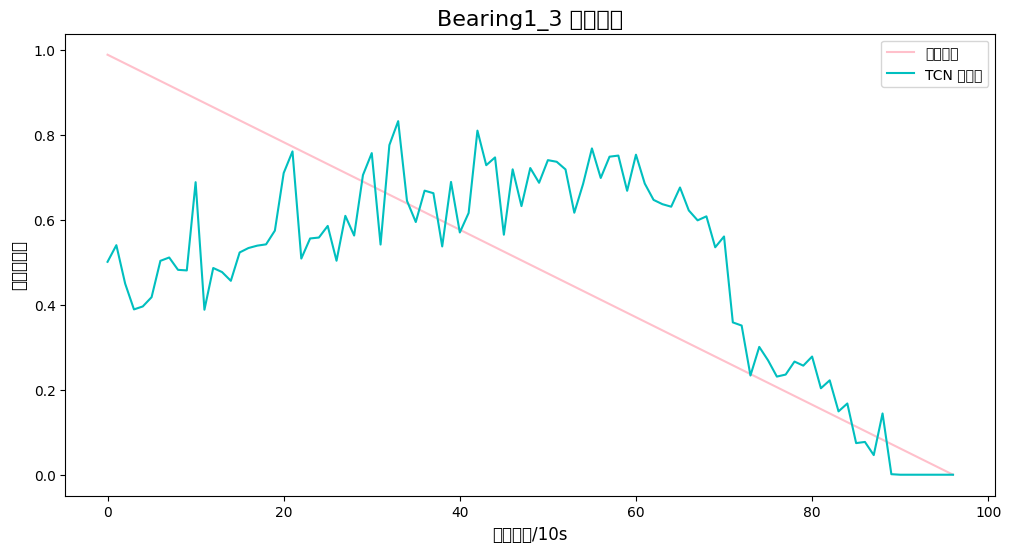

In [30]:
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rc("font", family='Microsoft YaHei')

# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_origin_data, label='真实寿命',color='pink')  # 真实值
plt.plot(test_pre_data, label='TCN 预测值',color='c')  # 预测值

# plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')  # 临界点直线  可自己调整位置

plt.xlabel('运行周期/10s', fontsize=12)
plt.ylabel('寿命百分比', fontsize=12)
plt.title(f'{TEST_xj[0]} 预测结果', fontsize=16)
plt.legend()
plt.show()

# 保存数据
dump(test_origin_data, '../画图对比/tcn_origin') 
dump(test_pre_data, '../画图对比/tcn_pre') 
import pandas as pd

# 将真实值和预测值保存为csv，真实值在第一列，预测值在第二列
result_df = pd.DataFrame(np.column_stack([test_origin_data, test_pre_data]))
result_df.to_csv(TEST_xj[0]+'_tcnsa_result.csv', index=False, header=False, encoding='utf-8')
# 把当前使用的超参数也保存下来，命名为 TEST_xj[0]+'_bilstm_result.json'

import json

# 假设你的超参数字典变量名为 config，如果不是请替换为实际使用的变量名
# 为了避免出错，可通过读取你实际用到的配置文件
with open('../../config/tcn_config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

with open(TEST_xj[0]+'_tcnsa_result.json', 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)